## Natural Language Processing, Sentiment Analysis, and Recommendation Modeling
#### Authors: Fennec Nighintgale, Matthew Lipman

In this notebook, we will be walking through using Faiss Kmeans algorithm and Naive Bayes to classify and model sentiment on Tweets and Youtube comments all relating to interstellar travel and space.

### Libraries

In [65]:
import faiss
import math
import pandas as pd
import numpy as np
from datetime import datetime

import scipy
from scipy.linalg import norm
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, coo_matrix, hstack, vstack

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_samples, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

### Functions

In [2]:
def get_sentiment_an(df):
  """
  Given a pandas dataframe, this will shuffle it & get sentiment 
  analysis values from TextBlob & VaderSentiment & assign columns inplace
  Will return completed dataframe & dataframe columns we'll be using for
  modeling as a coo_matrix. 
                Columns returned: 
  'polarity' : mean of text sentiment (TextBlob)
  'neg': negative sentiment value (VaderSentiment)
  'pos': positive sentiment value (VaderSentiment)
  'neu': neutral sentiment value (VaderSeniment)
  """
  # shuffling our dataframe so data is no longer sorted
  df = df.sample(frac = 1)
  df = df.reset_index().rename(columns={'index':'id'})
  # getting rid of all unnessecary columns
  df = df[['favorite_count', 'repost_count', 'text', 'id']]
  # feature generation using polarization 
  df['polarity'] = df['text'].apply(lambda x: 
                                    TextBlob(x).sentiment.polarity)
  # feature generation using intensity analyzer 
  analyzer = SentimentIntensityAnalyzer()
  df['pol'] = ''
  for i in range(len(df)):
    sentence = df.at[i, 'text']
    df.at[i, 'pol'] = analyzer.polarity_scores(sentence)
  for i in range(len(df)):
    for h in ['neg', 'neu', 'pos']:
      df.at[i, h] = float(df['pol'][i][h])
  #turning our other variables into a matrix to combine our features 
  maxab = MaxAbsScaler()
  drop = ['text', 'pol', 'id']
  hstack = maxab.fit_transform(coo_matrix(df.drop(labels=drop,  axis=1)))
  return df, hstack

In [3]:
def word_transform(df):
  """
  Pass in a pandas dataframe and this will return a coo_matrix
  featuring the TFIDF vectorization of your text, with a maximum
  of 100 features of single words and 100 features of bigrams. 
  """
  sing = TfidfVectorizer(max_features=100).fit_transform(df['text'])
  bi = TfidfVectorizer(ngram_range = (2, 2), 
                       max_features=100).fit_transform(df['text'])
  vect = coo_matrix(np.append(bi.toarray(), sing.toarray(), axis=1))
  return vect 

In [4]:
def svd_pca(vect, haystack):
  """
  Pass in your coo_matrix of your word vectors & the scaled 
  features from your dataframe this will perform Principal Component 
  Analysis in order to keep your most relevant 100 features, calculated
   in chunks to avoid RAM issues. It will return a numpy
   array containing all of the data for your model. 
  """
  svd = TruncatedSVD(n_components=95, n_iter=250000, 
                     random_state=0, algorithm='arpack').fit(vect)
  # splitting it so we never keep it all in RAM at once as an array 
  splits = []
  shape = vect.shape[1]
  tbs = vect 
  # since you cant directly index a matrix the easiest way is train_test
  # chose 50000 since my computer can handle it 
  while shape > 50000:
      shape = shape - 50000
      # first, run through the whole matrix 
      split1, split2 = train_test_split(tbs, random_state=0, 
                                        train_size=shape)
      #all of our leftover rows (not in the 30k) are in split2
      tbs = split2
      # put the chunk of our matrix into a list to iterate over later 
      splits.append(split1)
  # append the remainder (whatever was left < 30k) to the end of our list 
  splits.append(tbs)
  # start a new matrix by fit transforming our first chunk
  init = coo_matrix(svd.fit_transform(splits[0]))
  # start a loop that will fit transform and stack matricies together
  for item in splits[1:]:
      # fit transform will return it as a dense array 
      init = vstack([init, coo_matrix(svd.fit_transform(item))])
  # combine our text matrix & our repost/favorite matrix
  return np.append(haystack.toarray(), 
                   init.toarray(), axis=1).astype(np.float32)

In [5]:
def vect_and_stck(dataframe, first_run, drop_clust):
  """
  Pass in a DataFrame & this function will preprocess and return your
  dataframe & all of the columns nessecary to model as an array
  The first step is to get sentiment analysis scores, 
  which is only nessecary the first time you run this, otherwise
  they can be turned to False to save time, 
  sentiment analysis is followed by TDIDF vectorizaton on 
  single words & bigrams, and lastly it ends with PCA to reduce 
  our dimensions to a reasonable amount. Make drop_clust True to
  return a copy of your dataframe with no cluster column before 
  rerunning your model on it. 
  """
  if first_run == True:
    dataframe, haystack = get_sentiment_an(dataframe)
  else:
    clmn = ['neg', 'neu', 'pos', 'polarity',
            'repost_count', 'favorite_count']
    haystack = coo_matrix(dataframe[clmn])
  vect = word_transform(dataframe)
  if drop_clust == True:
    dataframe = dataframe.drop('cluster', 1)
  return svd_pca(vect, haystack), dataframe

In [6]:
def plt_elbow(haystack, df, display):
  """
  Plots your clusters from k 1-5 and returns the best one as an int,
  if display is true it will display the elbow plot, if not it will 
  just return your value. 
  """
  max = 5
  K = range(1,max+1)
  # start numpy arrays to store results in 
  inertias = np.zeros(max)
  diff = np.zeros(max)
  diff2 = np.zeros(max)
  diff3 = np.zeros(max)
  for k in K:
    kmeans, predictions = clusterizer(haystack, df, False)
    inertias[k - 1] = kmeans.obj[-1]
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    elif k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    elif k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]
  # use differences & numpy argmin to determine best cluster
  elbow = np.argmin(diff3[3:]) + 3
  if display == True: 
    print(f'Elbow {str(elbow)}')
    plt.plot(K, inertias, 'b*-')
    plt.plot(K[elbow], inertias[elbow], marker='o', markersize=12,
                markeredgewidth=2, markeredgecolor='r')
    plt.ylabel('Inertia')
    plt.xlabel('K')
    plt.show()
  elbow = int(elbow)
  global findimb
  findimb += elbow - 1
  return elbow

In [7]:
def chunked_samples(dataframe, stack, fit_predict, drop):
  """
  Given your dataframe, feature array/matrix & predictions 
  Computes Silhouette Scores using sklearn and chunking 
  the data into sets of 75000 and returns a deep copy of
  your dataframe with the silhouette scores in the column 
  'sil' Scores will not be perfect as this function chunks them, and 
  therefore cannot get complete pairwise distances  
  but without chunking silhouette scores cannot be run on 
  any computer or service we can find and it will be pretty close.
  Use drop = True to calculate the z-score of your silhouette scores
  and get rid of the bottom 10%, assuming they're likely to be outliers. 
  """
  start = 0 
  clust = 75000
  for i in range(math.ceil(stack.shape[0]/75000)):
    df = dataframe[start:start+clust].reset_index(drop=True).copy()
    fp = np.ravel(fit_predict[start:start+clust][0:])
    if type(stack) != np.ndarray:
      hstk = stack.toarray()[start:start+clust][0:]
    else:
      hstk = stack[start:start+clust][0:]
    df['sil'] = silhouette_samples(hstk, fp)
    if i == 0:
      head = df
    else:
      head = head.append(df) 
    if drop == True:
      mean = head['sil'].mean()
      std = head['sil'].std()
      head.reset_index(drop=True, inplace=True)
      for j in range(len(head)):
        head.at[j, 'silstd'] = (head.at[j, 'sil'] - mean)/std
      head = head.loc[head['silstd'] > -1.28].drop('silstd', 1)
    start += 75000
  return head.sample(frac=1).reset_index(drop=True).copy()

In [8]:
def quick_silhouette(dataframe, stack, fit_predict):
  """
  Pass in your dataframe, your feature array/matrix, 
  & your predictions, and this will use chunked_samples
  to get your score & try to quickly form a matplotlib visual
  Scores won't be 100% accurate as you cannot get pairwise distances 
  with chunking, but they use a sample size of 75,000 so they should
  be close, and the decrease in accuracy is well worth the 6-7 hours
  in speed it saves
  """
  _dataframe = chunked_samples(dataframe, stack, fit_predict, False)
  silhouette_vals = _dataframe['sil'].to_frame().to_numpy()
  labels = np.unique(fit_predict)
  y_ax_lower, y_ax_upper = 0, 0
  yticks = []
  for i, c in enumerate(labels):
    c_silhouette_vals = silhouette_vals[fit_predict == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / labels.shape[0])
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, 
             height=1.0, color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
  plt.axvline(np.mean(silhouette_vals), color="red", linestyle="--") 
  plt.yticks(yticks, labels + 1)
  plt.ylabel('Cluster')
  plt.xlabel('Silhouette Coefficient')
  plt.show()

In [9]:
def get_imb_clstr(dataframe):
  """
  Pass in your dataframe and get the cluster with the most values in it 
  returned as an interger 
  """
  clstr = dataframe['cluster'].value_counts()
  clstr = int(clstr.to_frame().reset_index()['index'][0])
  return clstr

In [10]:
def reset_clusters(new_predict, dataframe):
  """
  Pass in your new predictions and your dataframe 
  and it will renumber all of your clusters. 
  Be sure to use this before making visuals, if you don't
  clusters that have been reassigned will just appear to be missing.
  Edits your dataframe inplace. This is intentionally slower in 
  the hopes of not crashing my ram by iterating over each line one by one
  """
  _clusters = [int(x) for x in np.unique(new_predict)]
  _range = list(range(len(_clusters)))
  to_rename = {}
  for num in _range:
    to_rename[_clusters[num]] = num
  for i in range(len(dataframe)):
    dataframe.at[i, 'cluster'] = to_rename[dataframe.at[i, 'cluster']]

In [11]:
def add_new_clst(df, dataframe, k, num_clust):
  """
  Pass in your new predictions and your dataframe 
  and it will reassign the cluster you modeled to its new
  cluster assignments. Edits dataframe inplace. 
  """
  for i in [x for x in df.index]:
    cluster = df.at[i, 'cluster'] + k + 1 * num_clust
    _id = df.at[i, 'id']
    index = dataframe.loc[dataframe['id'] == _id].index[0]
    dataframe.at[index, 'cluster'] = cluster

In [12]:
def clusterizer(matrix, dataframe, calc_k):
  """
  Pass in your feature array/matrix and your dataframe
  If you would like to have k be calculated for you using the 
  elbow method with a maximum number of 5 clusters, do so by
  setting calc_k = True, otherwise, k will be 3 
  """
  global k 
  if calc_k == True:
    k = plt_elbow(matrix, dataframe, False)
  else: 
    k = 3 
  if type(matrix) != np.ndarray:
    matrix = matrix.toarray()
  shape = matrix.shape[0]
  kmeans = faiss.Kmeans(d = matrix.shape[1], k = k, nredo = 250,
                        update_index = True, seed = 42, 
                        max_points_per_centroid = math.ceil(shape/k),
                        min_points_per_centroid = math.floor(shape/k), 
                        niter = 20)
  kmeans.train(matrix)
  predict = kmeans.index.search(matrix, 1)[1]
  dataframe['cluster'] = predict
  return kmeans, predict

In [13]:
def get_slice(df, cluster):
  '''
  Pass in your dataframe and return just the values predicted to be in the
  largest cluster. 
  '''
  return df.loc[df['cluster'] == cluster].reset_index(drop=True)

In [80]:
# def showconfusionmatrix(y_t, y_hat_t, title):
#     """
#     Plots confusion matrix for provided y_train, y_hat_train 
#     OR y_test, y_hat_test 
#     """
#     fig, ax = plot_confusion_matrix(confusion_matrix(y_t, y_hat_t))
#     ax.set_title(f'{title} Data')
#     ax.set_xticks([0, 1])
#     ax.set_xticklabels(['True', 'False'])
#     ax.set_yticks([0, 1])
#     ax.set_yticklabels(['True', 'False'])
#     ax.set_ylabel('Actual Data')
#     ax.set_xlabel('Predicted Data')
#     plt.show()

In [15]:
def printreports(y_test, y_hat_test, y_train, y_hat_train):
    """
    Provided all input & predicted y values, prints classification 
    report for training and testing data right next to each other"""
    print('                                                      ')
    print('               Testing Report:')
    report1 = classification_report(y_test, y_hat_test)
    print(report1)
    print('_____________________________________________________')
    print('               Training Report:')
    report2 = classification_report(y_train, y_hat_train)
    print(report2)
    print('_____________________________________________________')

In [62]:
# creating a pipeline
def pipeline(name_of_pipeline, classifier, X_train, y_train, X_test, y_test):
    '''Creates and displays the pipeline classifiers along with the report of metrics'''
    name_of_pipeline = Pipeline([('classifier', classifier)])
    name_of_pipeline.fit(X_train, y_train)
    y_pred_test = name_of_pipeline.predict(X_test)
    y_pred_train = name_of_pipeline.predict(X_train)
    
    report = classification_report(y_test, y_pred_test, output_dict=True)
    df = pd.DataFrame(report).transpose()
    
    print(df)
    print('\n\n')
    print(name_of_pipeline.fit(X_train, y_train))
    print('\n\n')
    print('Training Accuracy: ', round(accuracy_score(y_train, y_pred_train),3))
    print('Testing Accuracy: ', round(accuracy_score(y_test, y_pred_test),3))
    print('\n\n')
    return

In [68]:
def visualizing_confusionmatrix(name_of_pipeline, classifier, X_train, y_train, X_test, y_test):
    '''Creates confusion matrices of the results from classifier'''
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    name_of_pipeline = Pipeline([('classifier', classifier)])
    name_of_pipeline.fit(X_train, y_train)
    y_pred_test = name_of_pipeline.predict(X_test)
    y_pred_train = name_of_pipeline.predict(X_train)
    
    #Plot Training Confusion Matrix
    plot_confusion_matrix(classifier, X_train, y_train, ax=axes[0,0],
                          display_labels=["0","1","2","3","4"])
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    #Plot Normalized Training Confusion Matrix
    plot_confusion_matrix(classifier, X_train, y_train, ax=axes[1,0], 
                          display_labels=["0","1","2","3","4"],
                          normalize='true')
    
    #Plot Test Confusion Matrix
    plot_confusion_matrix(classifier, X_test, y_test, ax=axes[0,1],
                          display_labels=["0","1","2","3","4"])
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    #Plot Normalized Test Confusion Matrix
    plot_confusion_matrix(classifier, X_test, y_test, ax=axes[1,1], 
                          display_labels=["0","1","2","3","4"],
                          normalize='true')
    
    axes[0,0].title.set_text(f'{classifier} Train')
    axes[0,1].title.set_text(f'{classifier} Test')
    axes[1,0].title.set_text(f'{classifier} Train')
    axes[1,1].title.set_text(f'{classifier} Test')
    
    plt.grid(False)
    plt.show()
    return

### Unsupervised Learning | Model Setup

First, we begin by loading our data and preprocessing. Since our data has already been cleaned, tokenized, and lemmatized, the main focus is placed on feature generation and dimensionality reduction

In [16]:
# open data, low_memory = False because we have some mixed dtype columns, 
# they aren't one's we use anyways so not worried sbout it 
df = pd.read_csv("final_clean_6_word.csv", low_memory=False)

In [17]:
# tokenize and preprocess our data, turning it into a matrix 
matrix, df = vect_and_stck(df, True, False)
# taking an initial count to see how much we lose by the end 
start = [len(df), datetime.now()]

### Unsupervised Model | First Edition

In [18]:
# start our model & make our initial predictions 
first_means, predict = clusterizer(matrix, df, False)

#### Model Evaluation

In [19]:
# define a number to help us determine if any of our clusters has too many points in it 
findimb = k

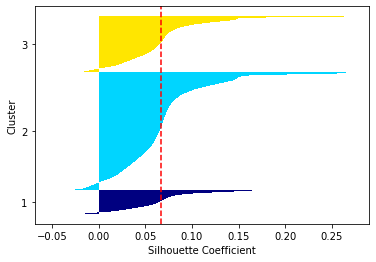

In [20]:
quick_silhouette(df, matrix, predict)

### Unsupervised Model Refinement

In [21]:
k = 3
num_clust = k
cl = get_imb_clstr(df)
# if our largest cluster is too large, we break it down into more clusters
while len(get_slice(df, cl)) >= len(df)/num_clust-1 and num_clust <= 9:
  # dropping outliers and shuffling our data  
  df = chunked_samples(df, matrix, predict, True)
  # processing our data without outliers 
  matrix, df = vect_and_stck(df, False, True)
  # re-modeling our data with less outliers 
  bttr_means, predict = clusterizer(matrix, df, False)
  # slicing our dataframe to get disproportionate cluster
  cl = get_imb_clstr(df)
  slice_matrix, slice_df = vect_and_stck(get_slice(df, cl), False, True)
  # plugging our new k value into a new model optimized for our cluster 
  clstr_means, clstr_pred = clusterizer(slice_matrix, slice_df, True)
  # updating our original datframe with our new clusters clusters
  add_new_clst(slice_df, df, k, num_clust)
  num_clust += k-1 

In [22]:
df = df.sample(frac = 1).reset_index(drop=True)
final_matrix, final_df = vect_and_stck(df, False, False)
final_clusters = np.ravel(final_df['cluster'].to_numpy())
reset_clusters(final_clusters, final_df)

#### Model Evaluation

In [71]:
final_clusters = final_df['cluster'].to_numpy()
# quick_silhouette(final_df, final_matrix, final_clusters)

In [27]:
end = [len(final_df), datetime.now()]

### Bayesian Classification

In [28]:
from sklearn.pipeline import make_pipeline

gnb = make_pipeline(TfidfVectorizer(),  GaussianNB(var_smoothing=1e-20))
bnb = make_pipeline(TfidfVectorizer(), BernoulliNB())

In [29]:
categories = [x for x in final_df.columns]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(final_matrix, final_clusters, random_state=0)
print(f' {round(end[0]/start[0], 4)}% Unclassifiable')
time = end[1]-start[1]
print(f' Model took {time.total_seconds()/60} min to complete')

 0.8766% Unclassifiable
 Model took 81.59508173333333 min to complete


#### Model Evaluation

              precision    recall  f1-score       support
0              0.007689  0.703704  0.015212     54.000000
1              0.012211  0.697080  0.024001    274.000000
2              0.011855  0.082721  0.020737    544.000000
3              1.000000  0.668946  0.801639  79259.000000
4              0.038721  0.481172  0.071673    239.000000
accuracy       0.664539  0.664539  0.664539      0.664539
macro avg      0.214095  0.526724  0.186653  80370.000000
weighted avg   0.986419  0.664539  0.791003  80370.000000



Pipeline(steps=[('classifier', GaussianNB(var_smoothing=1e-20))])



Training Accuracy:  0.669
Testing Accuracy:  0.665





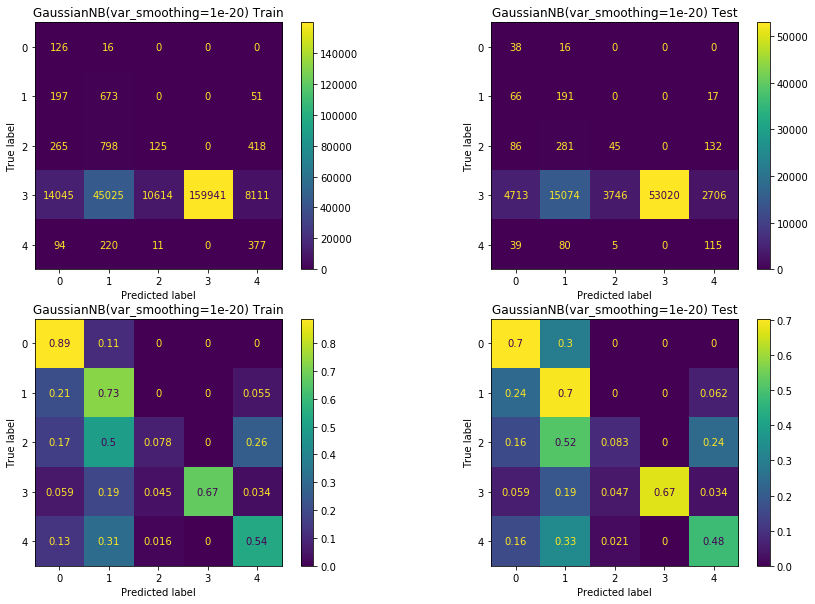

In [69]:
pipeline(gnb, GaussianNB(var_smoothing=1e-20), X_train, y_train, X_test, y_test)
visualizing_confusionmatrix(gnb, GaussianNB(var_smoothing=1e-20), X_train, y_train, X_test, y_test)

/Users/tlipman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score      support
0              0.000000  0.000000  0.000000     54.00000
1              0.061364  0.098540  0.075630    274.00000
2              0.037366  0.185662  0.062211    544.00000
3              0.989173  0.963689  0.976265  79259.00000
4              0.000000  0.000000  0.000000    239.00000
accuracy       0.951960  0.951960  0.951960      0.95196
macro avg      0.217581  0.249578  0.222821  80370.00000
weighted avg   0.975962  0.951960  0.963448  80370.00000



Pipeline(steps=[('classifier', BernoulliNB())])



Training Accuracy:  0.953
Testing Accuracy:  0.952





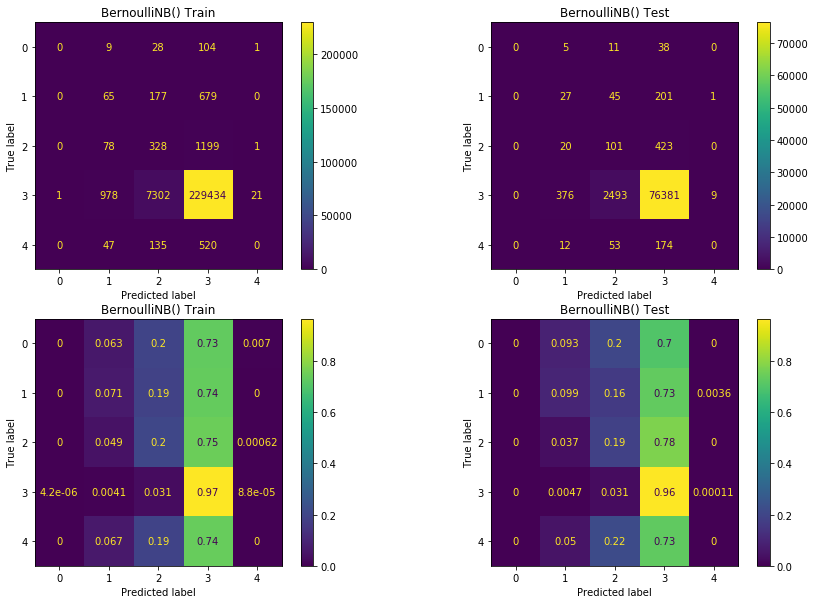

In [70]:
pipeline(bnb, BernoulliNB(), X_train, y_train, X_test, y_test)
visualizing_confusionmatrix(bnb, BernoulliNB(), X_train, y_train, X_test, y_test)

In [81]:
# gnb = GaussianNB(var_smoothing=1e-20)

# y_hat_test = gnb.fit(X_train, y_train).predict(X_test)
# y_hat_train = gnb.fit(X_train, y_train)
# showconfusionmatrix(y_test, y_hat_test, 'GNB')
# printreports(y_test, y_hat_test, y_train, y_hat_train)

TypeError: plot_confusion_matrix() missing 2 required positional arguments: 'X' and 'y_true'

In [75]:
# bnb = BernoulliNB() 

# y_hat_test = bnb.fit(X_train, y_train).predict(X_test)
# y_hat_train = bnb.fit(X_train, )
# showconfusionmatrix(y_test, y_hat_test, 'BNB')
# printreports(y_test, y_hat_test, y_train, y_hat_train)

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'colorbar'